In [1]:
import numpy as np
from scipy.spatial import ConvexHull
from numpy.linalg import matrix_rank, norm

def unique_with_threshold(points, threshold=1e-15):
    """Remove duplicate points within a given threshold."""
    if len(points) == 0:
        return points
    
    sorted_indices = np.lexsort(points.T)
    sorted_points = points[sorted_indices]
    
    diff = np.diff(sorted_points, axis=0)
    mask = np.ones(len(sorted_points), dtype=bool)
    mask[1:] = np.any(np.abs(diff) > threshold, axis=1)
    
    return sorted_points[mask]

def polyvolume(vertices):
    """Calculate the volume of a polyhedron defined by vertices."""
    vertices = unique_with_threshold(vertices, 1e-15)
    
    if vertices.shape[0] < 4:
        return False, np.nan
    
    if matrix_rank(vertices[1:] - vertices[0]) < 3:
        print('The points are coplanar or collinear.')
        return False, np.nan
    
    try:
        hull = ConvexHull(vertices)
    except:
        print('Convex hull computation failed.')
        return False, np.nan
    
    V = 0.0
    ref_point = np.mean(vertices, axis=0)
    
    for simplex in hull.simplices:
        face_vertices = vertices[simplex]
        tetrahedron = np.vstack([ref_point, face_vertices])
        
        a = tetrahedron[1] - tetrahedron[0]
        b = tetrahedron[2] - tetrahedron[0]
        c = tetrahedron[3] - tetrahedron[0]
        
        tetra_volume = np.abs(np.dot(a, np.cross(b, c))) / 6.0
        V += tetra_volume
    
    return True, V

def inpolyhedron(faces, vertices, point):
    """
    Check if a point is inside a polyhedron using ray-casting.
    Handles both triangular and polygonal faces.
    """
    ray = np.array([1, 0, 0])  # Ray in x-direction
    intersections = 0
    
    for face in faces:
        face_vertices = vertices[face]
        n_vertices = len(face_vertices)
        
        # Triangulate the polygon face
        for i in range(1, n_vertices - 1):
            # Create triangle from first vertex and two adjacent vertices
            triangle = [face_vertices[0], face_vertices[i], face_vertices[i + 1]]
            
            # Check if ray intersects triangle
            v0, v1, v2 = triangle
            edge1 = v1 - v0
            edge2 = v2 - v0
            h = np.cross(ray, edge2)
            a = np.dot(edge1, h)
            
            if abs(a) < 1e-15:
                continue  # Ray is parallel to triangle
                
            f = 1.0 / a
            s = point - v0
            u = f * np.dot(s, h)
            
            if u < 0.0 or u > 1.0:
                continue
                
            q = np.cross(s, edge1)
            v = f * np.dot(ray, q)
            
            if v < 0.0 or u + v > 1.0:
                continue
                
            t = f * np.dot(edge2, q)
            if t > 1e-15:  # Intersection
                intersections += 1
    
    return intersections % 2 == 1  # Odd number of intersections means inside

'''
def get_plane_intersections(vertices, faces, normal, offset):
    """
    Get intersections of a plane with polyhedron edges.
    """
    intersections = []
    
    for face in faces:
        face_vertices = vertices[face]
        n_vertices = len(face_vertices)
        
        # Check each edge of the face
        for i in range(n_vertices):
            v1 = face_vertices[i]
            v2 = face_vertices[(i + 1) % n_vertices]
            
            d1 = np.dot(normal, v1) - offset
            d2 = np.dot(normal, v2) - offset
            
            # Check if edge crosses the plane
            if d1 * d2 < 0:
                # Linear interpolation to find intersection point
                t = -d1 / (d2 - d1)
                intersection_point = v1 + t * (v2 - v1)
                intersections.append(intersection_point)
    
    return np.array(intersections) if intersections else np.array([])
'''


def intersect_plane_with_polyhedron(vertices, faces, D0, t, alpha):
    """
    Intersect plane with polyhedron and split it.
    
    Returns:
    isValid: whether the operation was successful
    midplane: intersection points with mid-plane
    upper: intersection points with upper plane
    down: intersection points with lower plane
    planeVertices: all plane intersection vertices
    subPoly1Vertices: vertices of first sub-polyhedron
    subPoly2Vertices: vertices of second sub-polyhedron
    """
    
    # Generate random normal vector
    normal = -1 + 2 * np.random.rand(3)
    normal = normal / norm(normal)
    
    min_coords = np.min(vertices, axis=0)
    max_coords = np.max(vertices, axis=0)
    
    inside = False
    point = None
    
    # Find a random point inside the polyhedron
    for i in range(5000):
        random_point = min_coords + (max_coords - min_coords) * np.random.rand(3)
        if inpolyhedron(faces, vertices, random_point):
            inside = True
            point = random_point
            break
    
    if not inside:
        return False, None, None, None, None, None, None
    
    # Calculate plane offsets
    D = D0 * (t + 1) ** (-alpha)
    offset1 = np.dot(normal, point) + D / 2
    offset2 = np.dot(normal, point) - D / 2
    mid = np.dot(normal, point)
    
    # Get intersections with planes
    intersections1 = get_plane_intersections(vertices, faces, normal, offset1)
    intersections2 = get_plane_intersections(vertices, faces, normal, offset2)
    intersections3 = get_plane_intersections(vertices, faces, normal, mid)
    
    if (intersections1.size > 0 and intersections2.size > 0 and 
        intersections1.shape[0] >= 3 and intersections2.shape[0] >= 3):
        
        # Split polyhedron (simplified - needs proper implementation)
        subPoly1Vertices, subPoly2Vertices = split_polyhedron_by_planes(
            vertices, faces, normal, offset1, offset2)
        
        # Calculate volumes
        _, originalVolume = polyvolume(vertices)
        is_v1, volume1 = polyvolume(subPoly1Vertices)
        is_v2, volume2 = polyvolume(subPoly2Vertices)
        
        # Check if we have enough points for volume calculation
        if len(intersections1) >= 3 and len(intersections2) >= 3:
            ispoly, planeVolume = polyvolume(np.vstack([intersections1, intersections2]))
        else:
            ispoly, planeVolume = False, 0.0
        
        if not ispoly or not is_v1 or not is_v2:
            return False, None, None, None, None, None, None
        
        planeVertices = np.vstack([intersections1, intersections2]) if intersections1.size > 0 and intersections2.size > 0 else np.array([])
        
        # Check volume conservation
        if abs(originalVolume - (volume1 + volume2 + planeVolume)) < 1e-7 and ispoly:
            return (True, intersections3, intersections1, intersections2, 
                    planeVertices, subPoly1Vertices, subPoly2Vertices)
        else:
            return False, None, None, None, None, None, None
    
    else:
        return False, None, None, None, None, None, None
    
def get_plane_intersections(vertices, faces, normal, offset):
    """
    Get intersections of a plane with polyhedron faces.
    
    Parameters:
    vertices: numpy array of shape (n, 3) containing 3D points
    faces: numpy array of face indices (each face should be triangular)
    normal: plane normal vector
    offset: plane offset (dot(normal, point) = offset)
    
    Returns:
    intersections: numpy array of intersection points
    """
    
    def is_point_in_triangle(pt, v1, v2, v3):
        """
        Check if a point is inside a triangle using barycentric coordinates.
        """
        u = v2 - v1
        v = v3 - v1
        w = pt - v1
        
        uv = np.dot(u, v)
        uu = np.dot(u, u)
        vv = np.dot(v, v)
        wu = np.dot(w, u)
        wv = np.dot(w, v)
        
        D = uv * uv - uu * vv
        
        if abs(D) < 1e-15:  # Use tolerance instead of exact equality
            return False
        
        s = (uv * wv - vv * wu) / D
        t_val = (uv * wu - uu * wv) / D
        
        return (s >= 0) and (t_val >= 0) and (s + t_val <= 1)
    
    intersections = []
    
    # Loop over each face (triangle) and check intersections
    for i in range(faces.shape[0]):
        face = faces[i]
        v1 = vertices[face[0]]
        v2 = vertices[face[1]]
        v3 = vertices[face[2]]
        
        # Calculate the intersection points with each edge of the triangle
        edges = [
            (v1, v2),  # Edge 1-2
            (v2, v3),  # Edge 2-3
            (v3, v1)   # Edge 3-1
        ]
        
        for v1_edge, v2_edge in edges:
            # Compute the intersection of edge with the plane
            denominator = np.dot(normal, v2_edge - v1_edge)
            
            # Skip if edge is parallel to plane
            if abs(denominator) < 1e-15:
                continue
                
            t = (offset - np.dot(normal, v1_edge)) / denominator
            
            if 0 <= t <= 1:
                intersection = v1_edge + t * (v2_edge - v1_edge)
                
                # Check if intersection is inside the triangle
                if is_point_in_triangle(intersection, v1, v2, v3):
                    intersections.append(intersection)
    
    return np.array(intersections) if intersections else np.array([])

def removeDuplicates(matrix):
    """
    Remove duplicate rows from a matrix by first sorting each row.
    
    Parameters:
    matrix: numpy array of shape (n, m)
    
    Returns:
    unique_matrix: numpy array with duplicate rows removed
    """
    if len(matrix) == 0:
        return matrix
    
    # Sort each row in ascending order
    sorted_matrix = np.sort(matrix, axis=1)
    
    # Find the unique rows in the sorted matrix
    _, unique_idx = np.unique(sorted_matrix, axis=0, return_index=True)
    
    # Sort the indices to maintain original order (equivalent to 'stable' in MATLAB)
    unique_idx = np.sort(unique_idx)
    
    # Extract the corresponding rows from the original matrix
    unique_matrix = matrix[unique_idx, :]
    
    return unique_matrix

# Alternative implementation that exactly matches MATLAB's 'stable' behavior
def removeDuplicates_stable(matrix):
    """
    Remove duplicate rows from a matrix while preserving original order.
    """
    if len(matrix) == 0:
        return matrix
    
    # Sort each row in ascending order
    sorted_matrix = np.sort(matrix, axis=1)
    
    # Use a dictionary to track unique rows while preserving order
    seen = {}
    unique_indices = []
    
    for i, row in enumerate(sorted_matrix):
        # Convert row to tuple for hashing
        row_tuple = tuple(row)
        if row_tuple not in seen:
            seen[row_tuple] = True
            unique_indices.append(i)
    
    # Extract the corresponding rows from the original matrix
    unique_matrix = matrix[unique_indices, :]
    
    return unique_matrix


def split_polyhedron_by_planes(vertices, faces, normal, offset1, offset2):
    """
    Split polyhedron by two parallel planes.
    
    Parameters:
    vertices: numpy array of shape (n, 3) containing 3D points
    faces: numpy array of face indices
    normal: plane normal vector
    offset1: offset for first plane (dot(normal, point) = offset1)
    offset2: offset for second plane (dot(normal, point) = offset2)
    
    Returns:
    subPoly1Vertices: vertices on the positive side of offset1 plane + intersections
    subPoly2Vertices: vertices on the negative side of offset2 plane + intersections
    """
    
    # Get intersections with both planes
    intersections1 = get_plane_intersections(vertices, faces, normal, offset1)
    intersections2 = get_plane_intersections(vertices, faces, normal, offset2)
    
    subPoly1Vertices = []
    subPoly2Vertices = []
    
    # Classify each vertex based on its position relative to the offset1 plane
    for i in range(vertices.shape[0]):
        # Calculate signed distance from vertex to plane
        # dot(normal, point) - offset1 > 0 means point is on positive side
        signed_distance = np.dot(normal, vertices[i]) - offset1
        
        if signed_distance > 0:
            subPoly1Vertices.append(vertices[i])
        else:
            subPoly2Vertices.append(vertices[i])
    
    # Convert lists to numpy arrays
    subPoly1Vertices = np.array(subPoly1Vertices)
    subPoly2Vertices = np.array(subPoly2Vertices)
    
    # Add intersection points to both polyhedrons
    if intersections1.size > 0:
        subPoly1Vertices = np.vstack([subPoly1Vertices, intersections1]) if subPoly1Vertices.size > 0 else intersections1
    
    if intersections2.size > 0:
        subPoly2Vertices = np.vstack([subPoly2Vertices, intersections2]) if subPoly2Vertices.size > 0 else intersections2
    
    return subPoly1Vertices, subPoly2Vertices

In [3]:
from scipy.spatial import ConvexHull
import numpy as np
import trimesh

def save_stl(results, output_name):
    all_vertices = []
    all_faces = []
    vertex_offset = 0

    for k, v in results['planes_coords'].items():
        if v is None or len(v) < 4:
            continue
    
        v = np.array(v)
        hull = ConvexHull(v)
        centroid = np.mean(v, axis=0)
    
        faces = []
        for simplex in hull.simplices:
            tri = v[simplex]
            n = np.cross(tri[1] - tri[0], tri[2] - tri[0])
            n /= np.linalg.norm(n)
            face_center = np.mean(tri, axis=0)
        
            # Ensure outward normal: points away from centroid
            if np.dot(n, face_center - centroid) < 0:
                simplex = [simplex[0], simplex[2], simplex[1]]  # flip face
        
            faces.append([i + vertex_offset for i in simplex])
    
        all_vertices.extend(v.tolist())
        all_faces.extend(faces)
        vertex_offset += len(v)

    # Build Trimesh and ensure all normals point outward
    mesh = trimesh.Trimesh(vertices=np.array(all_vertices),
                       faces=np.array(all_faces),
                       process=False)

    # Compute correct normals globally
    mesh.fix_normals()

    # Export STL
    mesh.export(output_name+".stl")

In [31]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import pickle

# Import all the helper functions we defined earlier
#from previous_functions import (
#    removeDuplicates, polyvolume, inpolyhedron, 
#    get_plane_intersections, split_polyhedron_by_planes,
#    intersect_plane_with_polyhedron
#)

#ai_d0 = {0:[0.01], .1:[0.015], .3:[0.03], .5:[0.05], .9:[0.1] }

alpha_list = [0.1]#, 0.1, 0.3, 0.5]  # [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
D0_list = [0.05]#[0.01, 0.02, 0.03]  # [0.05,0.2]
N = 150
    
#for ai in range(len(alpha_list)):
#        for di in range(len(D0_list)):
for ai in alpha_list:
    for di in D0_list: #ai_d0[ai]:
            for version in range(1):  # range(5)
                alpha = ai#alpha_list[ai]
                D0 = di #D0_list[di]
                num_planes = N
                
                # Define cube vertices
                vertices = np.array([
                    [0, 0, 0],
                    [1, 0, 0],
                    [1, 1, 0],
                    [0, 1, 0],
                    [0, 0, 1],
                    [1, 0, 1],
                    [1, 1, 1],
                    [0, 1, 1]
                ])
                
                # Compute convex hull
                hull = ConvexHull(vertices)
                faces = hull.simplices
                
                # Extract edges from faces
                edges = []
                for face in faces:
                    for i in range(len(face)):
                        edge = sorted([face[i], face[(i + 1) % len(face)]])
                        edges.append(edge)
                edges = removeDuplicates(np.array(edges))
                
                # Initialize data structures
                mid_plane_all = {}
                upper_plane_all = {}
                down_plane_all = {}
                planes_coords = {}
                poly_list = {}
                edges_list = {}
                faces_list = {}
                
                poly_list[0] = [vertices]
                edges_list[0] = [edges]
                faces_list[0] = [faces]
                
                t = 0
                trial = 1
                numP = 0
                
                # Main loop
                while trial < 1e4:
                    # Calculate volumes and probabilities
                    tmp_volume = np.zeros(len(poly_list[t]))
                    for v in range(len(poly_list[t])):
                        _, volume_temp = polyvolume(poly_list[t][v])
                        tmp_volume[v] = volume_temp
                    
                    if np.sum(tmp_volume) == 0:
                        break
                    
                    prob = tmp_volume / np.sum(tmp_volume)
                    cumulativeProbabilities = np.cumsum(prob)
                    r = np.random.rand()
                    selectedIndex = np.where(cumulativeProbabilities >= r)[0][0]
                    
                    current_vertices = poly_list[t][selectedIndex]
                    current_edges = edges_list[t][selectedIndex]
                    current_face = faces_list[t][selectedIndex]
                    
                    # Try to intersect with plane
                    result = intersect_plane_with_polyhedron(
                        current_vertices, current_face, D0, t, alpha
                    )
                    
                    isValid, midplane, upper, down, planeVertices, subPoly1Vertices, subPoly2Vertices = result
                    
                    if isValid:
                        # Store plane information
                        mid_plane_all[t] = midplane
                        upper_plane_all[t] = upper
                        down_plane_all[t] = down
                        planes_coords[t] = planeVertices
                        
                        # Update polyhedron lists
                        poly_list[t + 1] = poly_list[t].copy()
                        del poly_list[t + 1][selectedIndex]
                        
                        edges_list[t + 1] = edges_list[t].copy()
                        del edges_list[t + 1][selectedIndex]
                        
                        faces_list[t + 1] = faces_list[t].copy()
                        del faces_list[t + 1][selectedIndex]
                        
                        # Compute convex hulls for new sub-polyhedrons
                        try:
                            hull1 = ConvexHull(subPoly1Vertices)
                            faces1 = hull1.simplices
                            edges1 = []
                            for face in faces1:
                                for i in range(len(face)):
                                    edge = sorted([face[i], face[(i + 1) % len(face)]])
                                    edges1.append(edge)
                            edges1 = removeDuplicates(np.array(edges1))
                        except:
                            continue
                        
                        try:
                            hull2 = ConvexHull(subPoly2Vertices)
                            faces2 = hull2.simplices
                            edges2 = []
                            for face in faces2:
                                for i in range(len(face)):
                                    edge = sorted([face[i], face[(i + 1) % len(face)]])
                                    edges2.append(edge)
                            edges2 = removeDuplicates(np.array(edges2))
                        except:
                            continue
                        
                        # Add new sub-polyhedrons
                        poly_list[t + 1].append(subPoly1Vertices)
                        poly_list[t + 1].append(subPoly2Vertices)
                        
                        edges_list[t + 1].append(edges1)
                        edges_list[t + 1].append(edges2)
                        
                        faces_list[t + 1].append(faces1)
                        faces_list[t + 1].append(faces2)
                        
                        numP += 1
                        t += 1
                        print(f'Added plane number {t}')
                        
                    else:
                        trial += 1
                    
                    if numP >= num_planes:
                        print('Done')
                        break
                

                vol = 0
                for k,v in planes_coords.items():
                    hull = ConvexHull(v)
                    vol += hull.volume

                print(f'Volume of all planes: {vol}')

                # Save results (you can modify this part to save data as needed)
                results = {
                    'mid_plane_all': mid_plane_all,
                    'upper_plane_all': upper_plane_all,
                    'down_plane_all': down_plane_all,
                    'planes_coords': planes_coords,
                    'poly_list': poly_list,
                    'alpha': alpha,
                    'D0': D0,
                    'run_time': version,
                    'volume':vol
                }
                
                # You can save the results to a file here
                # np.savez(f'results_alpha_{alpha}_D0_{D0}_run_{run_time}.npz', **results)
                
                #save results in a pkl file

                output_file_name = f'./3D_Plates/results_alpha_{alpha}_D0_{D0}_p{N}_ver{version}_volume{int(100*np.round(vol,2))}'
                #with open(output_file_name + '.pkl', 'wb') as f:
                #    pickle.dump(results, f)

                #save stl
                #save_stl(results, output_file_name)

Added plane number 1
Added plane number 2
Added plane number 3
Added plane number 4
Added plane number 5
Added plane number 6
Added plane number 7
Added plane number 8
Added plane number 9
Added plane number 10
The points are coplanar or collinear.
Added plane number 11
Added plane number 12
Added plane number 13
Added plane number 14
Added plane number 15
Added plane number 16
Added plane number 17
Added plane number 18
The points are coplanar or collinear.
Added plane number 19
Added plane number 20
Added plane number 21
Added plane number 22
Added plane number 23
Added plane number 24
Added plane number 25
Added plane number 26
Added plane number 27
Added plane number 28
Added plane number 29
Added plane number 30
Added plane number 31
Added plane number 32
Added plane number 33
Added plane number 34
Added plane number 35
Added plane number 36
Added plane number 37
Added plane number 38
Added plane number 39
Added plane number 40
Added plane number 41
Added plane number 42
Added pla

In [28]:
results.keys()

dict_keys(['mid_plane_all', 'upper_plane_all', 'down_plane_all', 'planes_coords', 'poly_list', 'alpha', 'D0', 'run_time', 'volume'])

In [32]:
path = '/Users/csababoth/Work/3DNetwork/NetMat/ScaleRich_model/Code_mit/Code_1/3D/SI_fig/'
save_stl(results, path+'a01_l005')

Volume of all planes: 0.45959435301611745


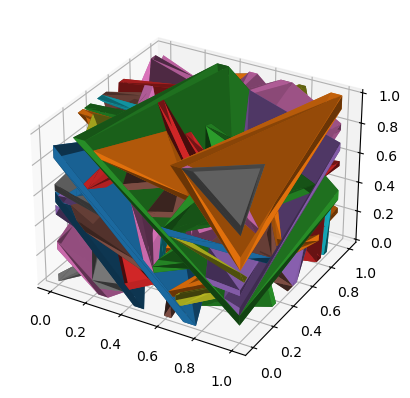

In [33]:
#3d plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


from scipy.spatial import ConvexHull

vol = 0
for k,v in results['planes_coords'].items():
    hull = ConvexHull(v)
    #volume of the hull
    vol += hull.volume
    ax.plot_trisurf(v[:,0], v[:,1], v[:,2], triangles=hull.simplices, alpha=1)

print(f'Volume of all planes: {vol}')

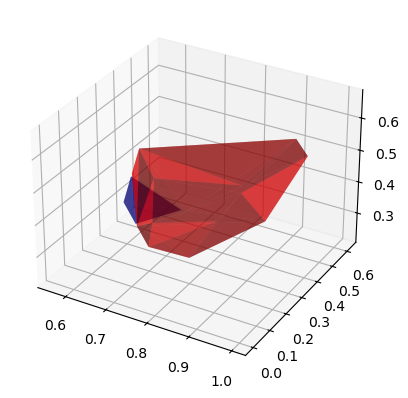

In [7]:
hull1, hull2

#plot hull1 and hull2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(hull1.points[:,0], hull1.points[:,1], hull1.points[:,2], triangles=hull1.simplices, alpha=0.5, color='blue')
ax.plot_trisurf(hull2.points[:,0], hull2.points[:,1], hull2.points[:,2], triangles=hull2.simplices, alpha=0.5, color='red')